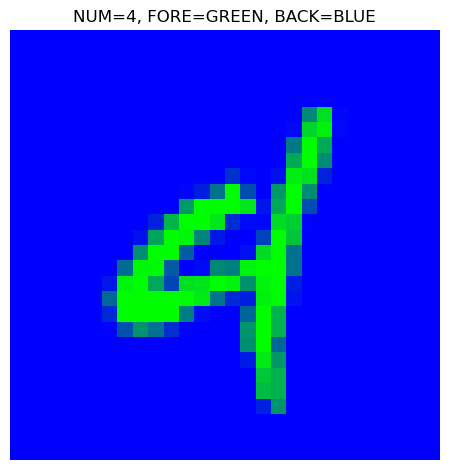

In [35]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

np.random.seed(42)  # 난수 생성기의 초기값 설정 (재현성 보장)

# MNIST 데이터셋을 로드합니다.
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 무지개 색상 팔레트를 정의합니다 (7가지 색상).
RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
]

RAINBOW_NAMES = [
    'RED',
    'ORANGE',
    'YELLOW',
    'GREEN',
    'BLUE',
    'INDIGO',
    'VIOLET'
]

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGBA')
    return colored_digit

def overlay_digit_on_background(colored_digit):
    """투명도를 제거하고 일관된 배경 이미지를 생성합니다."""
    final_image = colored_digit.convert('RGB')  # 투명도를 제거합니다.
    return final_image

# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
idx = np.random.randint(0, len(mnist))  # 0~9 사이의 숫자
image, label = mnist[idx]
pil_image = transforms.ToPILImage()(image)

# 전경과 배경 색상을 무작위로 선택합니다.
fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()

# 전경과 배경 색상이 같지 않도록 보장합니다.
while bg_color == fg_color:
  bg_color, bg_label = get_random_rainbow_color()

# 선택된 색상으로 숫자 이미지를 색칠합니다.
colored_digit = colorize_digit(pil_image, fg_color, bg_color)

if image is not None:
  # 최종 이미지를 표시합니다.
  final_image = overlay_digit_on_background(colored_digit)
  plt.imshow(final_image)
  plt.axis('off')  # 축을 비활성화합니다.
  plt.title(f'NUM={label}, FORE={fg_label}, BACK={bg_label}')

  # 레이아웃을 조정하고 화면에 표시합니다.
  plt.tight_layout()
  plt.show()

In [37]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [7]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# X_color를 (60000, 28, 28, 3)에서 (60000, 2352)로 변환 (flatten)
X_color = np.array(X_color).reshape(-1, 28 * 28 * 3)

# 변환된 X_color_flat의 shape 확인
print(X_color.shape)  # (60000, 2352)

# X_color와 y_fg, y_bg, y_digit에 대한 훈련/검증 세트를 나누기
X_train, X_test = X_color[:50000], X_color[50000:]
y_train_fg, y_test_fg = y_fg[:50000], y_fg[50000:]
y_train_bg, y_test_bg = y_bg[:50000], y_bg[50000:]
y_train_digit, y_test_digit = y_digit[:50000], y_digit[50000:]

# X_train, y_train_fg, y_train_bg, y_train_digit을 한 번에 훈련/검증 세트로 나누기
X_train_split, X_val_split, y_train_fg_split, y_val_fg_split, y_train_bg_split, y_val_bg_split, y_train_digit_split, y_val_digit_split = train_test_split(
    X_train, y_train_fg, y_train_bg, y_train_digit, test_size=0.1, random_state=42
)

(60000, 2352)


In [9]:
# RandomForest 모델
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 학습
start_time_fg = time.time()
rf_model_fg.fit(X_train_split, y_train_fg_split)
end_time_fg = time.time()

start_time_bg = time.time()
rf_model_bg.fit(X_train_split, y_train_bg_split)
end_time_bg = time.time()

start_time_digit = time.time()
rf_model_digit.fit(X_train_split, y_train_digit_split)
end_time_digit = time.time()

# 검증 데이터로 예측
start_time_fg_val = time.time()
y_val_fg_pred = rf_model_fg.predict(X_val_split)
end_time_fg_val = time.time()

start_time_bg_val = time.time()
y_val_bg_pred = rf_model_bg.predict(X_val_split)
end_time_bg_val = time.time()

start_time_digit_val = time.time()
y_val_digit_pred = rf_model_digit.predict(X_val_split)
end_time_digit_val = time.time()

training_time_fg = end_time_fg - start_time_fg
training_time_bg = end_time_bg - start_time_bg
training_time_digit = end_time_digit - start_time_digit

training_time_fg_val = end_time_fg_val - start_time_fg_val
training_time_bg_val = end_time_bg_val - start_time_bg_val
training_time_digit_val = end_time_digit_val - start_time_digit_val

accuracy_fg_rf = accuracy_score(y_val_fg_split, y_val_fg_pred)
accuracy_bg_rf = accuracy_score(y_val_bg_split, y_val_bg_pred)
accuracy_digit_rf = accuracy_score(y_val_digit_split, y_val_digit_pred)

print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg_rf:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {training_time_fg_val:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg_rf:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {training_time_bg_val:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit_rf:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {training_time_digit_val:.2f} 초")

Random Forest 전경 색상(fg) 정확도: 0.9994
Random Forest 전경 색상(fg) 학습 시간: 38.07 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.25 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 13.50 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.07 초
Random Forest 숫자(digit) 정확도: 0.9300
Random Forest 숫자(digit) 학습 시간: 67.09 초
Random Forest Validation 숫자(digit) 예측 시간: 0.42 초


In [13]:
pip install tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/390.3 MB ? eta -:--:--
    --------------------------------------- 5.0/390.3 MB 23.2 MB/s eta 0:00:17
   - -------------------------------------- 10.0/390.3 MB 23.9 MB/s eta 0:00:16
   - -------------------------------------- 14.4/390.3 MB 22.6 MB/s eta 0:00:17
   - -------------------------------------- 19.4/390.3 MB 23.1 MB/s eta 0:00:17
   -- ------------------------------------- 24.6/390.3 MB 23.3 MB/s eta 0:00:16
   --- ------------------------------------ 30.4/390.3 MB 23.8 MB/s eta 0:00:16
   --- ------------------------------------ 35.4/390.3 MB 23.9 MB/s eta 0:00:15
   --- ------------------------------------ 37.2/390.3 MB 22.3 MB/s eta 0:00:16
   ---- ----------------------------------- 42.5/390.3 MB 22.3 MB/s eta 0:00:16
   ---- ----------------------------------- 48.0/390.3 MB 22.8 MB/s eta 0:00:16
   ----- ---------------------------------- 52.7/390.

In [29]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)


In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from joblib import Parallel, delayed

# 회전 각도 리스트
rotation_angles = [5, 10, 15, 20, 25, 30]

# 결과 저장용 리스트
results = []

# 병렬 처리: 각 회전 각도에 대해 실행
def process_rotation(angle):
    print(f"\n===== 회전 각도: {angle}° =====")
    
    # ImageDataGenerator 설정 (회전만 적용)
    datagen = ImageDataGenerator(
        rotation_range=angle,  # 회전 각도
        fill_mode='nearest'    # 회전 시 빈 공간 채우기
    )

    # 증강 데이터 생성
    augmented_images = []
    augmented_digit_labels = []

    for i in range(len(X_color)):
        img = X_color[i].reshape((1, 28, 28, 3))  # 배치 차원 추가
        digit_label = y_digit[i]

        augmented_iter = datagen.flow(img, batch_size=1)
        augmented_img = next(augmented_iter)[0].astype('uint8')  # 증강된 이미지 생성

        augmented_images.append(augmented_img)
        augmented_digit_labels.append(digit_label)  # digit 레이블 추가

    # Numpy 배열로 변환
    augmented_images = np.array(augmented_images)
    augmented_digit_labels = np.array(augmented_digit_labels)

    # 원본 데이터와 증강 데이터 결합
    final_X_color = np.concatenate([X_color, augmented_images], axis=0)
    final_y_digit = np.concatenate([y_digit, augmented_digit_labels], axis=0)

    # 데이터를 평탄화
    final_X_color_flat = final_X_color.reshape(final_X_color.shape[0], -1)

    # 데이터 분할
    X_train_val, X_test, y_digit_train_val, y_digit_test = train_test_split(
        final_X_color_flat, final_y_digit, test_size=0.1, random_state=42
    )

    X_train, X_val, y_digit_train, y_digit_val = train_test_split(
        X_train_val, y_digit_train_val, test_size=0.1, random_state=42
    )

    # Random Forest 모델 선언
    rf_digit = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

    # 학습 및 시간 측정
    start_digit = time.time()
    rf_digit.fit(X_train, y_digit_train)
    end_digit = time.time()

    # 검증 데이터로 예측
    y_digit_pred = rf_digit.predict(X_val)

    # 정확도 계산
    accuracy_digit = accuracy_score(y_digit_val, y_digit_pred)

    # 결과 반환
    return {
        'rotation_angle': angle,
        'accuracy_digit': accuracy_digit,
        'training_time_digit': end_digit - start_digit
    }

# 병렬 처리로 회전 각도 테스트
start_total = time.time()
results = Parallel(n_jobs=-1)(delayed(process_rotation)(angle) for angle in rotation_angles)
end_total = time.time()

# 결과 출력
print("\n===== 모든 실험 결과 =====")
for res in results:
    print(f"\n회전 각도: {res['rotation_angle']}°")
    print(f"  숫자(digit) 정확도: {res['accuracy_digit']:.4f}, 학습 시간: {res['training_time_digit']:.2f} 초")

print(f"\n총 소요 시간: {(end_total - start_total) / 60:.2f} 분")



===== 모든 실험 결과 =====

회전 각도: 5°
  숫자(digit) 정확도: 0.9767, 학습 시간: 216.00 초

회전 각도: 10°
  숫자(digit) 정확도: 0.9637, 학습 시간: 218.10 초

회전 각도: 15°
  숫자(digit) 정확도: 0.9580, 학습 시간: 217.96 초

회전 각도: 20°
  숫자(digit) 정확도: 0.9486, 학습 시간: 209.09 초

회전 각도: 25°
  숫자(digit) 정확도: 0.9406, 학습 시간: 210.01 초

회전 각도: 30°
  숫자(digit) 정확도: 0.9356, 학습 시간: 209.97 초

총 소요 시간: 4.30 분


In [27]:
from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

# 파라미터 범위 설정
rotation_ranges = [5, 10, 15]  # 회전 각도
brightness_ranges = [[0.8, 1.2], [0.7, 1.3]]  # 밝기 범위
zoom_ranges = [0.1, 0.2, 0.3]  # 확대/축소 범위

# 모든 조합 생성
augmentation_params = [
    {'rotation_range': r, 'brightness_range': b, 'zoom_range': z}
    for r, b, z in product(rotation_ranges, brightness_ranges, zoom_ranges)
]

print(f"총 생성된 조합: {len(augmentation_params)}")  # 조합 개수 확인

# 결과 저장용 리스트
results = []

for idx, params in enumerate(augmentation_params):
    print(f"\n===== 실험 {idx+1}: {params} =====")
    
    # ImageDataGenerator 설정
    datagen = ImageDataGenerator(
        rotation_range=params['rotation_range'],
        brightness_range=params['brightness_range'],
        zoom_range=params['zoom_range'],
        fill_mode='nearest'
    )

    # 증강 데이터 생성
    augmented_images = []
    augmented_digit_labels = []

    for i in range(len(X_color)):
        img = X_color[i].reshape((1, 28, 28, 3))  # Keras에서 요구하는 배치 차원 추가
        digit_label = y_digit[i]

        augmented_iter = datagen.flow(img, batch_size=1)
        augmented_img = next(augmented_iter)[0].astype('uint8')  # 증강된 이미지 생성

        augmented_images.append(augmented_img)
        augmented_digit_labels.append(digit_label)  # digit 레이블 추가

    # Numpy 배열로 변환
    augmented_images = np.array(augmented_images)
    augmented_digit_labels = np.array(augmented_digit_labels)

    # 원본 데이터와 증강 데이터 결합
    final_X_color = np.concatenate([X_color, augmented_images], axis=0)
    final_y_digit = np.concatenate([y_digit, augmented_digit_labels], axis=0)

    # 데이터를 평탄화
    final_X_color_flat = final_X_color.reshape(final_X_color.shape[0], -1)

    # 데이터 분할
    X_train_val, X_test, y_digit_train_val, y_digit_test = train_test_split(
        final_X_color_flat, final_y_digit, test_size=0.1, random_state=42
    )

    X_train, X_val, y_digit_train, y_digit_val = train_test_split(
        X_train_val, y_digit_train_val, test_size=0.1, random_state=42
    )

    # Random Forest 모델 선언
    rf_digit = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # 학습 및 시간 측정
    start_digit = time.time()
    rf_digit.fit(X_train, y_digit_train)
    end_digit = time.time()

    # 검증 데이터로 예측
    y_digit_pred = rf_digit.predict(X_val)

    # 정확도 계산
    accuracy_digit = accuracy_score(y_digit_val, y_digit_pred)

    # 결과 저장
    results.append({
        'params': params,
        'accuracy_digit': accuracy_digit,
        'training_time_digit': end_digit - start_digit
    })

    # 현재 결과 출력
    print(f"숫자(digit) 정확도: {accuracy_digit:.4f}")
    print(f"숫자(digit) 학습 시간: {end_digit - start_digit:.2f} 초")

# 전체 결과 출력
print("\n===== 모든 실험 결과 =====")
for idx, res in enumerate(results):
    print(f"\n실험 {idx+1}: {res['params']}")
    print(f"  숫자(digit) 정확도: {res['accuracy_digit']:.4f}, 학습 시간: {res['training_time_digit']:.2f} 초")


총 생성된 조합: 18

===== 실험 1: {'rotation_range': 5, 'brightness_range': [0.8, 1.2], 'zoom_range': 0.1} =====
숫자(digit) 정확도: 0.9578
숫자(digit) 학습 시간: 59.76 초

===== 실험 2: {'rotation_range': 5, 'brightness_range': [0.8, 1.2], 'zoom_range': 0.2} =====
숫자(digit) 정확도: 0.9423
숫자(digit) 학습 시간: 53.84 초

===== 실험 3: {'rotation_range': 5, 'brightness_range': [0.8, 1.2], 'zoom_range': 0.3} =====
숫자(digit) 정확도: 0.9252
숫자(digit) 학습 시간: 56.01 초

===== 실험 4: {'rotation_range': 5, 'brightness_range': [0.7, 1.3], 'zoom_range': 0.1} =====
숫자(digit) 정확도: 0.9547
숫자(digit) 학습 시간: 56.23 초

===== 실험 5: {'rotation_range': 5, 'brightness_range': [0.7, 1.3], 'zoom_range': 0.2} =====
숫자(digit) 정확도: 0.9401
숫자(digit) 학습 시간: 54.82 초

===== 실험 6: {'rotation_range': 5, 'brightness_range': [0.7, 1.3], 'zoom_range': 0.3} =====
숫자(digit) 정확도: 0.9164
숫자(digit) 학습 시간: 56.00 초

===== 실험 7: {'rotation_range': 10, 'brightness_range': [0.8, 1.2], 'zoom_range': 0.1} =====
숫자(digit) 정확도: 0.9512
숫자(digit) 학습 시간: 53.98 초

===== 실험 8: 

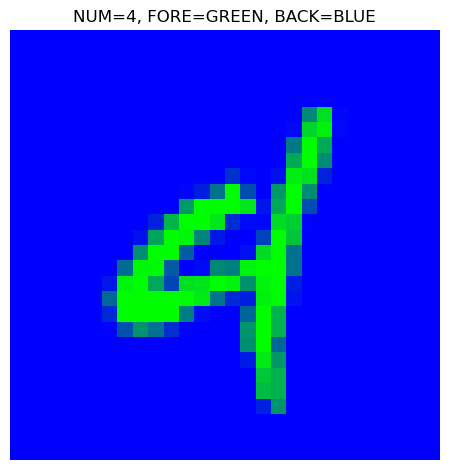

X_color.shape: (60000, 28, 28, 3)
y_digit.shape: (60000,)
y_fg.shape: (60000,)
y_bg.shape: (60000,)
(60000, 2352)
Raw Data
Random Forest 전경 색상(fg) 정확도: 0.9996
Random Forest 전경 색상(fg) 학습 시간: 41.49 초
Random Forest Validation 전경 색상(fg) 예측 시간: 0.20 초
Random Forest 배경 색상(bg) 정확도: 1.0000
Random Forest 배경 색상(bg) 학습 시간: 14.02 초
Random Forest Validation 배경 색상(bg) 예측 시간: 0.07 초
Random Forest 숫자(digit) 정확도: 0.9331
Random Forest 숫자(digit) 학습 시간: 69.92 초
Random Forest Validation 숫자(digit) 예측 시간: 0.32 초


In [33]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

np.random.seed(42)  # 난수 생성기의 초기값 설정 (재현성 보장)

# MNIST 데이터셋을 로드합니다.
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 무지개 색상 팔레트를 정의합니다 (7가지 색상).
RAINBOW_COLORS = [
    (255, 0, 0),    # 빨강
    (255, 127, 0),  # 주황
    (255, 255, 0),  # 노랑
    (0, 255, 0),    # 초록
    (0, 0, 255),    # 파랑
    (75, 0, 130),   # 남색 (인디고)
    (148, 0, 211)   # 보라
]

RAINBOW_NAMES = [
    'RED',
    'ORANGE',
    'YELLOW',
    'GREEN',
    'BLUE',
    'INDIGO',
    'VIOLET'
]

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGBA')
    return colored_digit

def overlay_digit_on_background(colored_digit):
    """투명도를 제거하고 일관된 배경 이미지를 생성합니다."""
    final_image = colored_digit.convert('RGB')  # 투명도를 제거합니다.
    return final_image

# 전경과 배경 색상이 있는 MNIST 데이터셋을 생성하고 표시합니다.
idx = np.random.randint(0, len(mnist))  # 0~9 사이의 숫자
image, label = mnist[idx]
pil_image = transforms.ToPILImage()(image)

# 전경과 배경 색상을 무작위로 선택합니다.
fg_color, fg_label = get_random_rainbow_color()
bg_color, bg_label = get_random_rainbow_color()

# 전경과 배경 색상이 같지 않도록 보장합니다.
while bg_color == fg_color:
  bg_color, bg_label = get_random_rainbow_color()

# 선택된 색상으로 숫자 이미지를 색칠합니다.
colored_digit = colorize_digit(pil_image, fg_color, bg_color)

if image is not None:
  # 최종 이미지를 표시합니다.
  final_image = overlay_digit_on_background(colored_digit)
  plt.imshow(final_image)
  plt.axis('off')  # 축을 비활성화합니다.
  plt.title(f'NUM={label}, FORE={fg_label}, BACK={bg_label}')

  # 레이아웃을 조정하고 화면에 표시합니다.
  plt.tight_layout()
  plt.show()

import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

# X_color를 (60000, 28, 28, 3)에서 (60000, 2352)로 변환 (flatten)
X_color = np.array(X_color).reshape(-1, 28 * 28 * 3)

# 변환된 X_color_flat의 shape 확인
print(X_color.shape)  # (60000, 2352)

# X_color와 y_fg, y_bg, y_digit에 대한 훈련/검증 세트를 나누기
X_train, X_test = X_color[:50000], X_color[50000:]
y_train_fg, y_test_fg = y_fg[:50000], y_fg[50000:]
y_train_bg, y_test_bg = y_bg[:50000], y_bg[50000:]
y_train_digit, y_test_digit = y_digit[:50000], y_digit[50000:]

# X_train, y_train_fg, y_train_bg, y_train_digit을 한 번에 훈련/검증 세트로 나누기
X_train_split, X_val_split, y_train_fg_split, y_val_fg_split, y_train_bg_split, y_val_bg_split, y_train_digit_split, y_val_digit_split = train_test_split(
    X_train, y_train_fg, y_train_bg, y_train_digit, test_size=0.1, random_state=42
)

# 1. 데이터 분할
# 데이터를 평탄화 (flatten)하여 RandomForest에서 사용할 수 있도록 변환
X_color_flat = X_color.reshape(X_color.shape[0], -1)

# 90% 훈련+검증 / 10% 테스트로 분할
X_train_val, X_test, y_fg_train_val, y_fg_test, y_bg_train_val, y_bg_test, y_digit_train_val, y_digit_test = train_test_split(
    X_color_flat, y_fg, y_bg, y_digit, test_size=0.1, random_state=42
)

# 훈련+검증 데이터를 다시 훈련/검증 세트로 나눔 (90% 훈련 / 10% 검증)
X_train, X_val, y_fg_train, y_fg_val, y_bg_train, y_bg_val, y_digit_train, y_digit_val = train_test_split(
    X_train_val, y_fg_train_val, y_bg_train_val, y_digit_train_val, test_size=0.1, random_state=42
)

# 2. Random Forest 모델 학습 및 검증
# 모델 초기화
rf_fg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bg = RandomForestClassifier(n_estimators=100, random_state=42)
rf_digit = RandomForestClassifier(n_estimators=100, random_state=42)

# 학습 및 시간 측정
start_fg = time.time()
rf_fg.fit(X_train, y_fg_train)
end_fg = time.time()

start_bg = time.time()
rf_bg.fit(X_train, y_bg_train)
end_bg = time.time()

start_digit = time.time()
rf_digit.fit(X_train, y_digit_train)
end_digit = time.time()

# 검증 데이터로 예측
val_start_fg = time.time()
y_fg_pred = rf_fg.predict(X_val)
val_end_fg = time.time()

val_start_bg = time.time()
y_bg_pred = rf_bg.predict(X_val)
val_end_bg = time.time()

val_start_digit = time.time()
y_digit_pred = rf_digit.predict(X_val)
val_end_digit = time.time()

# 3. 정확도 계산
accuracy_fg = accuracy_score(y_fg_val, y_fg_pred)
accuracy_bg = accuracy_score(y_bg_val, y_bg_pred)
accuracy_digit = accuracy_score(y_digit_val, y_digit_pred)

# 학습 및 예측 시간 계산
training_time_fg = end_fg - start_fg
training_time_bg = end_bg - start_bg
training_time_digit = end_digit - start_digit

validation_time_fg = val_end_fg - val_start_fg
validation_time_bg = val_end_bg - val_start_bg
validation_time_digit = val_end_digit - val_start_digit

# 4. 결과 출력
print(f"Raw Data")
print(f"Random Forest 전경 색상(fg) 정확도: {accuracy_fg:.4f}")
print(f"Random Forest 전경 색상(fg) 학습 시간: {training_time_fg:.2f} 초")
print(f"Random Forest Validation 전경 색상(fg) 예측 시간: {validation_time_fg:.2f} 초")

print(f"Random Forest 배경 색상(bg) 정확도: {accuracy_bg:.4f}")
print(f"Random Forest 배경 색상(bg) 학습 시간: {training_time_bg:.2f} 초")
print(f"Random Forest Validation 배경 색상(bg) 예측 시간: {validation_time_bg:.2f} 초")

print(f"Random Forest 숫자(digit) 정확도: {accuracy_digit:.4f}")
print(f"Random Forest 숫자(digit) 학습 시간: {training_time_digit:.2f} 초")
print(f"Random Forest Validation 숫자(digit) 예측 시간: {validation_time_digit:.2f} 초")


In [ ]:
import torch
from torchvision import datasets, transforms
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

#모델 학습을 위한 데이터 적재
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X_color = []
y_bg = []
y_fg = []
y_digit = []

def get_random_rainbow_color():
    """무지개 팔레트에서 임의의 색상을 선택합니다."""
    # return tuple(np.random.randint(0, 256, size=3))
    idx = np.random.randint(0, len(RAINBOW_COLORS))
    return RAINBOW_COLORS[idx], RAINBOW_NAMES[idx]

def colorize_digit(digit_image, fg_color, bg_color):
    """숫자 이미지에 전경(fg)과 배경(bg) 색상을 적용합니다."""
    digit = digit_image.convert('L')  # 이미지를 그레이스케일로 변환합니다.
    colored_digit = ImageOps.colorize(digit, black=bg_color, white=fg_color).convert('RGB')
    return colored_digit

for i in range(len(mnist)):
    image, label = mnist[i]
    pil_image = transforms.ToPILImage()(image)

    # 전경과 배경 색상을 무작위로 선택합니다.
    fg_color, fg_label = get_random_rainbow_color()
    bg_color, bg_label = get_random_rainbow_color()

    # 전경과 배경 색상이 같지 않도록 보장합니다.
    while bg_color == fg_color:
        bg_color, bg_label = get_random_rainbow_color()

    # 전경 및 배경 색상이 적용된 숫자 이미지를 생성합니다.
    colored_digit = colorize_digit(pil_image, fg_color, bg_color)

    # 결과 이미지를 numpy 배열로 변환하고 리스트에 추가합니다.
    X_color.append(np.array(colored_digit))
    y_digit.append(label)
    y_fg.append(fg_label)
    y_bg.append(bg_label)

#리스트를 Numpy로 변환
X_color = np.array(X_color)
y_digit = np.array(y_digit)
y_fg = np.array(y_fg)
y_bg = np.array(y_bg)

# 데이터 형태를 확인합니다.
print(f"X_color.shape: {X_color.shape}")
print(f"y_digit.shape: {y_digit.shape}")
print(f"y_fg.shape: {y_fg.shape}")
print(f"y_bg.shape: {y_bg.shape}")

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from joblib import Parallel, delayed

# 회전 각도 리스트 (0°~5°)
rotation_angles = [0, 1, 2, 3, 4, 5]

# 결과 저장용 리스트
results = []

# 병렬 처리: 각 회전 각도에 대해 실행
def process_rotation(angle):
    print(f"\n===== 회전 각도: {angle}° =====")
    
    # 0°는 원본 데이터를 사용
    if angle == 0:
        final_X_color = X_color
        final_y_digit = y_digit
    else:
        # ImageDataGenerator 설정 (회전만 적용)
        datagen = ImageDataGenerator(
            rotation_range=angle,  # 회전 각도
            fill_mode='nearest'    # 회전 시 빈 공간 채우기
        )

        # 증강 데이터 생성
        augmented_images = []
        augmented_digit_labels = []

        for i in range(len(X_color)):
            img = X_color[i].reshape((1, 28, 28, 3))  # 배치 차원 추가
            digit_label = y_digit[i]

            augmented_iter = datagen.flow(img, batch_size=1)
            augmented_img = next(augmented_iter)[0].astype('uint8')  # 증강된 이미지 생성

            augmented_images.append(augmented_img)
            augmented_digit_labels.append(digit_label)  # digit 레이블 추가

        # Numpy 배열로 변환
        augmented_images = np.array(augmented_images)
        augmented_digit_labels = np.array(augmented_digit_labels)

        # 원본 데이터와 증강 데이터 결합
        final_X_color = np.concatenate([X_color, augmented_images], axis=0)
        final_y_digit = np.concatenate([y_digit, augmented_digit_labels], axis=0)

    # 데이터를 평탄화
    final_X_color_flat = final_X_color.reshape(final_X_color.shape[0], -1)

    # 데이터 분할
    X_train_val, X_test, y_digit_train_val, y_digit_test = train_test_split(
        final_X_color_flat, final_y_digit, test_size=0.1, random_state=42
    )

    X_train, X_val, y_digit_train, y_digit_val = train_test_split(
        X_train_val, y_digit_train_val, test_size=0.1, random_state=42
    )

    # Random Forest 모델 선언
    rf_digit = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # 학습 및 시간 측정
    start_digit = time.time()
    rf_digit.fit(X_train, y_digit_train)
    end_digit = time.time()

    # 검증 데이터로 예측
    y_digit_pred = rf_digit.predict(X_val)

    # 정확도 계산
    accuracy_digit = accuracy_score(y_digit_val, y_digit_pred)

    # 결과 반환
    return {
        'rotation_angle': angle,
        'accuracy_digit': accuracy_digit,
        'training_time_digit': end_digit - start_digit
    }

# 병렬 처리로 회전 각도 테스트
start_total = time.time()
results = Parallel(n_jobs=-1)(delayed(process_rotation)(angle) for angle in rotation_angles)
end_total = time.time()

# 결과 출력
print("\n===== 모든 실험 결과 =====")
for res in results:
    print(f"\n회전 각도: {res['rotation_angle']}°")
    print(f"  숫자(digit) 정확도: {res['accuracy_digit']:.4f}, 학습 시간: {res['training_time_digit']:.2f} 초")

print(f"\n총 소요 시간: {(end_total - start_total) / 60:.2f} 분")



===== 모든 실험 결과 =====

회전 각도: 0°
  숫자(digit) 정확도: 0.9331, 학습 시간: 38.58 초

회전 각도: 1°
  숫자(digit) 정확도: 0.9841, 학습 시간: 179.22 초

회전 각도: 2°
  숫자(digit) 정확도: 0.9830, 학습 시간: 218.15 초

회전 각도: 3°
  숫자(digit) 정확도: 0.9815, 학습 시간: 139.71 초

회전 각도: 4°
  숫자(digit) 정확도: 0.9806, 학습 시간: 165.24 초

회전 각도: 5°
  숫자(digit) 정확도: 0.9775, 학습 시간: 217.36 초

총 소요 시간: 4.32 분


In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from joblib import Parallel, delayed

# 회전 각도 리스트 (0.1° ~ 1.0°, 0.1 간격)
rotation_angles = [round(angle, 1) for angle in np.arange(0.1, 1.1, 0.1)]

# 결과 저장용 리스트
results = []

# 병렬 처리: 각 회전 각도에 대해 실행
def process_rotation(angle):
    print(f"\n===== 회전 각도: {angle}° =====")
    
    # ImageDataGenerator 설정 (회전만 적용)
    datagen = ImageDataGenerator(
        rotation_range=angle,  # 회전 각도
        fill_mode='nearest'    # 회전 시 빈 공간 채우기
    )

    # 증강 데이터 생성
    augmented_images = []
    augmented_digit_labels = []

    for i in range(len(X_color)):
        img = X_color[i].reshape((1, 28, 28, 3))  # 배치 차원 추가
        digit_label = y_digit[i]

        augmented_iter = datagen.flow(img, batch_size=1)
        augmented_img = next(augmented_iter)[0].astype('uint8')  # 증강된 이미지 생성

        augmented_images.append(augmented_img)
        augmented_digit_labels.append(digit_label)  # digit 레이블 추가

    # Numpy 배열로 변환
    augmented_images = np.array(augmented_images)
    augmented_digit_labels = np.array(augmented_digit_labels)

    # 원본 데이터와 증강 데이터 결합
    final_X_color = np.concatenate([X_color, augmented_images], axis=0)
    final_y_digit = np.concatenate([y_digit, augmented_digit_labels], axis=0)

    # 데이터를 평탄화
    final_X_color_flat = final_X_color.reshape(final_X_color.shape[0], -1)

    # 데이터 분할
    X_train_val, X_test, y_digit_train_val, y_digit_test = train_test_split(
        final_X_color_flat, final_y_digit, test_size=0.1, random_state=42
    )

    X_train, X_val, y_digit_train, y_digit_val = train_test_split(
        X_train_val, y_digit_train_val, test_size=0.1, random_state=42
    )

    # Random Forest 모델 선언
    rf_digit = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # 학습 및 시간 측정
    start_digit = time.time()
    rf_digit.fit(X_train, y_digit_train)
    end_digit = time.time()

    # 검증 데이터로 예측
    y_digit_pred = rf_digit.predict(X_val)

    # 정확도 계산
    accuracy_digit = accuracy_score(y_digit_val, y_digit_pred)

    # 결과 반환
    return {
        'rotation_angle': angle,
        'accuracy_digit': accuracy_digit,
        'training_time_digit': end_digit - start_digit
    }

# 병렬 처리로 회전 각도 테스트
start_total = time.time()
results = Parallel(n_jobs=-1)(delayed(process_rotation)(angle) for angle in rotation_angles)
end_total = time.time()

# 결과 출력
print("\n===== 모든 실험 결과 =====")
for res in results:
    print(f"\n회전 각도: {res['rotation_angle']}°")
    print(f"  숫자(digit) 정확도: {res['accuracy_digit']:.4f}, 학습 시간: {res['training_time_digit']:.2f} 초")

print(f"\n총 소요 시간: {(end_total - start_total) / 60:.2f} 분")



===== 모든 실험 결과 =====

회전 각도: 0.1°
  숫자(digit) 정확도: 0.9869, 학습 시간: 178.65 초

회전 각도: 0.2°
  숫자(digit) 정확도: 0.9858, 학습 시간: 178.60 초

회전 각도: 0.3°
  숫자(digit) 정확도: 0.9867, 학습 시간: 228.37 초

회전 각도: 0.4°
  숫자(digit) 정확도: 0.9871, 학습 시간: 222.24 초

회전 각도: 0.5°
  숫자(digit) 정확도: 0.9846, 학습 시간: 230.93 초

회전 각도: 0.6°
  숫자(digit) 정확도: 0.9862, 학습 시간: 205.07 초

회전 각도: 0.7°
  숫자(digit) 정확도: 0.9856, 학습 시간: 174.83 초

회전 각도: 0.8°
  숫자(digit) 정확도: 0.9856, 학습 시간: 182.26 초

회전 각도: 0.9°
  숫자(digit) 정확도: 0.9845, 학습 시간: 141.24 초

회전 각도: 1.0°
  숫자(digit) 정확도: 0.9844, 학습 시간: 128.07 초

총 소요 시간: 7.37 분


In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from joblib import Parallel, delayed

# 밝기 범위 리스트
brightness_ranges = [
    [0.8, 1.2],
    [0.9, 1.1],
    [0.7, 1.3],
    [0.6, 1.4],
    [1.0, 1.2],
]

# 결과 저장용 리스트
results = []

# 병렬 처리: 각 밝기 범위에 대해 실행
def process_brightness(brightness_range):
    print(f"\n===== 밝기 범위: {brightness_range} =====")
    
    # ImageDataGenerator 설정 (밝기 조정 추가, 회전 고정)
    datagen = ImageDataGenerator(
        rotation_range=0.4,  # 회전 각도 고정
        brightness_range=brightness_range,  # 밝기 범위
        fill_mode='nearest'  # 빈 공간 채우기
    )

    # 증강 데이터 생성
    augmented_images = []
    augmented_digit_labels = []

    for i in range(len(X_color)):
        img = X_color[i].reshape((1, 28, 28, 3))  # 배치 차원 추가
        digit_label = y_digit[i]

        augmented_iter = datagen.flow(img, batch_size=1)
        augmented_img = next(augmented_iter)[0].astype('uint8')  # 증강된 이미지 생성

        augmented_images.append(augmented_img)
        augmented_digit_labels.append(digit_label)  # digit 레이블 추가

    # Numpy 배열로 변환
    augmented_images = np.array(augmented_images)
    augmented_digit_labels = np.array(augmented_digit_labels)

    # 원본 데이터와 증강 데이터 결합
    final_X_color = np.concatenate([X_color, augmented_images], axis=0)
    final_y_digit = np.concatenate([y_digit, augmented_digit_labels], axis=0)

    # 데이터를 평탄화
    final_X_color_flat = final_X_color.reshape(final_X_color.shape[0], -1)

    # 데이터 분할
    X_train_val, X_test, y_digit_train_val, y_digit_test = train_test_split(
        final_X_color_flat, final_y_digit, test_size=0.1, random_state=42
    )

    X_train, X_val, y_digit_train, y_digit_val = train_test_split(
        X_train_val, y_digit_train_val, test_size=0.1, random_state=42
    )

    # Random Forest 모델 선언
    rf_digit = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # 학습 및 시간 측정
    start_digit = time.time()
    rf_digit.fit(X_train, y_digit_train)
    end_digit = time.time()

    # 검증 데이터로 예측
    y_digit_pred = rf_digit.predict(X_val)

    # 정확도 계산
    accuracy_digit = accuracy_score(y_digit_val, y_digit_pred)

    # 결과 반환
    return {
        'brightness_range': brightness_range,
        'accuracy_digit': accuracy_digit,
        'training_time_digit': end_digit - start_digit
    }

# 병렬 처리로 밝기 범위 테스트
start_total = time.time()
results = Parallel(n_jobs=-1)(delayed(process_brightness)(brightness_range) for brightness_range in brightness_ranges)
end_total = time.time()

# 결과 출력
print("\n===== 모든 실험 결과 =====")
for res in results:
    print(f"\n밝기 범위: {res['brightness_range']}")
    print(f"  숫자(digit) 정확도: {res['accuracy_digit']:.4f}, 학습 시간: {res['training_time_digit']:.2f} 초")

print(f"\n총 소요 시간: {(end_total - start_total) / 60:.2f} 분")



===== 모든 실험 결과 =====

밝기 범위: [0.8, 1.2]
  숫자(digit) 정확도: 0.9786, 학습 시간: 217.41 초

밝기 범위: [0.9, 1.1]
  숫자(digit) 정확도: 0.9805, 학습 시간: 160.25 초

밝기 범위: [0.7, 1.3]
  숫자(digit) 정확도: 0.9726, 학습 시간: 210.56 초

밝기 범위: [0.6, 1.4]
  숫자(digit) 정확도: 0.9725, 학습 시간: 167.24 초

밝기 범위: [1.0, 1.2]
  숫자(digit) 정확도: 0.9834, 학습 시간: 208.46 초

총 소요 시간: 4.30 분
